In [4]:
import numpy as np
import torch
file_path = '../sample_file/q_map_0.txt'
matrix = np.loadtxt(file_path)
matrix = matrix.reshape(1,1,128,128)
matrix = torch.tensor(matrix)
matrix

tensor([[[[0.1432, 0.1585, 0.1564,  ..., 0.1804, 0.1989, 0.1776],
          [0.1565, 0.1589, 0.1434,  ..., 0.1721, 0.2131, 0.1897],
          [0.1538, 0.1448, 0.1235,  ..., 0.1301, 0.1768, 0.1753],
          ...,
          [0.1529, 0.1469, 0.1261,  ..., 0.1240, 0.1705, 0.1755],
          [0.1549, 0.1598, 0.1464,  ..., 0.1659, 0.2052, 0.1891],
          [0.1387, 0.1549, 0.1519,  ..., 0.1783, 0.1953, 0.1791]]]],
       dtype=torch.float64)

In [5]:
def argmax2d(tensor):
  n = tensor.size(0)
  d = tensor.size(2)
  m = tensor.view(n, -1).argmax(1)
  return torch.cat(((m / d).view(-1, 1), (m % d).view(-1, 1)), dim=1)

argmax2d(matrix)[0]

tensor([92.2344, 30.0000])

In [6]:
copy_matrix = matrix.clone()
for i in range(100):
    max_index = argmax2d(copy_matrix)[0].long()
    print(max_index, copy_matrix[0][0][max_index[0]][max_index[1]])
    copy_matrix[0][0][max_index[0]][max_index[1]] = 0

tensor([92, 30]) tensor(0.6451, dtype=torch.float64)
tensor([93, 30]) tensor(0.6440, dtype=torch.float64)
tensor([11, 47]) tensor(0.5943, dtype=torch.float64)
tensor([93, 29]) tensor(0.5837, dtype=torch.float64)
tensor([92, 29]) tensor(0.5667, dtype=torch.float64)
tensor([12, 47]) tensor(0.5510, dtype=torch.float64)
tensor([11, 46]) tensor(0.5466, dtype=torch.float64)
tensor([92, 31]) tensor(0.5288, dtype=torch.float64)
tensor([ 64, 105]) tensor(0.5196, dtype=torch.float64)
tensor([10, 47]) tensor(0.5107, dtype=torch.float64)
tensor([12, 46]) tensor(0.4917, dtype=torch.float64)
tensor([ 64, 104]) tensor(0.4716, dtype=torch.float64)
tensor([93, 31]) tensor(0.4584, dtype=torch.float64)
tensor([10, 46]) tensor(0.4569, dtype=torch.float64)
tensor([ 63, 105]) tensor(0.4378, dtype=torch.float64)
tensor([ 63, 104]) tensor(0.4194, dtype=torch.float64)
tensor([11, 48]) tensor(0.4193, dtype=torch.float64)
tensor([103,  88]) tensor(0.4190, dtype=torch.float64)
tensor([91, 30]) tensor(0.4154, dtyp

In [46]:
import numpy as np
def argmax2d(tensor):
    n = tensor.size(0)
    d = tensor.size(2)
    m = tensor.view(n, -1).argmax(1)
    return torch.cat(((m / d).view(-1, 1), (m % d).view(-1, 1)), dim=1)

def set_center_region(submatrix, n, value):
    # 获取中心区域的边界
    min_row = submatrix.shape[0] // 2 - n // 2
    max_row = min_row + n
    min_col = submatrix.shape[1] // 2 - n // 2
    max_col = min_col + n

    # 将中心区域的值设置为指定值
    submatrix[min_row:max_row, min_col:max_col] = value
    return submatrix


def find_second_max(matrix, center, neighborhood_size=20, min_distance=10):

    a, b = center

    # 定义邻域的边界
    min_row = max(0, a - neighborhood_size // 2)
    max_row = min(matrix.shape[0], a + neighborhood_size // 2 + 1)
    min_col = max(0, b - neighborhood_size // 2)
    max_col = min(matrix.shape[1], b + neighborhood_size // 2 + 1)

    # 在邻域内找到次最大值的坐标
    submatrix = matrix[min_row:max_row, min_col:max_col]
    submatrix = set_center_region(submatrix, min_distance, 0)
    flattened_indices = np.argsort(submatrix, axis=None)  # 将邻域展平后的索引
    second_max_index = np.unravel_index(flattened_indices[-2], submatrix.shape)

    # 转换为全局坐标
    second_max_coord = (a - neighborhood_size // 2 + second_max_index[0],
                        b - neighborhood_size // 2 + second_max_index[1])

    return second_max_coord

file_path = '../sample_file/q_map_1.txt'
matrix = np.loadtxt(file_path)
matrix = torch.tensor(matrix)

# 找到最大值的坐标
max_coords = argmax2d(matrix.reshape(1,1,128,128)).long()[0]

# 找到次最大值的坐标
second_max_coords = find_second_max(matrix, max_coords)

print("最大值坐标:", max_coords)
print("次最大值坐标:", second_max_coords)


最大值坐标: tensor([72, 64])
次最大值坐标: (tensor(66), tensor(66))


In [17]:
import re
import matplotlib.pyplot as plt

# 定义一个字典来存储每个 action 的累计 reward 和计数器
action_rewards = {}

# 打开文件并逐行读取
with open("../temp/object_attacked_position.txt") as file:
    for line in file:
        # 解析每一行，提取出 action 和对应的 reward
        values = [float(match) for match in re.findall(r'[-+]?\d*\.\d+(?:[eE][-+]?\d+)?|\d+', line)]
        action = tuple(values[7:11])  # 提取 action，这里假设 action 是一个由四个元素组成的元组
        reward = values[-1]  # 提取 reward

        # 更新字典中对应 action 的累计 reward 和计数器
        if action in action_rewards:
            action_rewards[action]['total_reward'] += reward
            action_rewards[action]['count'] += 1
        else:
            action_rewards[action] = {'total_reward': reward, 'count': 1}

# 计算每个 action 的平均 reward
average_rewards = {}
for action, reward_info in action_rewards.items():
    average_reward = reward_info['total_reward'] / reward_info['count']
    average_rewards[action] = average_reward

# 提取每个动作的x和y坐标
x_coords = [action[0] for action in average_rewards.keys()]
y_coords = [action[1] for action in average_rewards.keys()]

# 画图

plt.scatter(x_coords, y_coords, s=1, c=list(average_rewards.values()), cmap='viridis')
plt.colorbar(label='Average Reward')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Average Reward for Each Action')
plt.grid(True)
plt.show()


TypeError: from_bounds() argument after * must be an iterable, not int

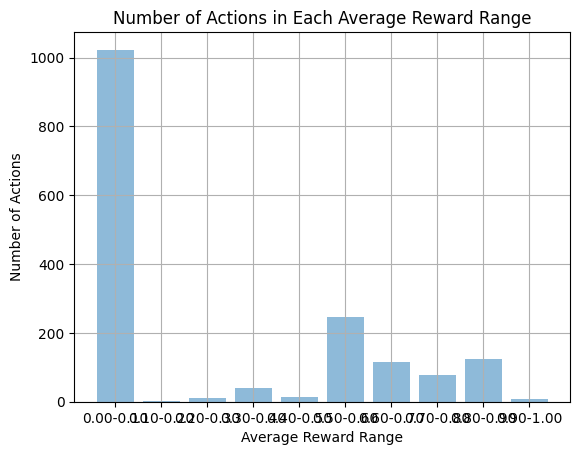

In [15]:
import re
import matplotlib.pyplot as plt
import numpy as np

# 定义一个字典来存储每个 action 的累计 reward 和计数器
action_rewards = {}

# 打开文件并逐行读取
with open("../temp/object_attacked_position.txt") as file:
    for line in file:
        # 解析每一行，提取出 action 和对应的 reward
        values = [float(match) for match in re.findall(r'[-+]?\d*\.\d+(?:[eE][-+]?\d+)?|\d+', line)]
        action = tuple(values[7:11])  # 提取 action，这里假设 action 是一个由四个元素组成的元组
        reward = values[-1]  # 提取 reward

        # 更新字典中对应 action 的累计 reward 和计数器
        if action in action_rewards:
            action_rewards[action]['total_reward'] += reward
            action_rewards[action]['count'] += 1
        else:
            action_rewards[action] = {'total_reward': reward, 'count': 1}

# 计算每个 action 的平均 reward
average_rewards = {}
for action, reward_info in action_rewards.items():
    average_reward = reward_info['total_reward'] / reward_info['count']
    average_rewards[action] = average_reward

# 提取每个动作的平均奖励值
average_rewards_values = list(average_rewards.values())

# 划分平均奖励区间
num_bins = 10
bins = np.linspace(min(average_rewards_values), max(average_rewards_values), num_bins + 1)

# 统计每个区间内动作的数量
action_counts = {i: 0 for i in range(num_bins)}
for reward in average_rewards_values:
    for i in range(num_bins):
        if bins[i] <= reward < bins[i+1]:
            action_counts[i] += 1
            break

# 绘制柱状图
plt.bar(range(num_bins), action_counts.values(), align='center', alpha=0.5)
plt.xticks(range(num_bins), [f"{bins[i]:.2f}-{bins[i+1]:.2f}" for i in range(num_bins)])
plt.xlabel('Average Reward Range')
plt.ylabel('Number of Actions')
plt.title('Number of Actions in Each Average Reward Range')
plt.grid(True)
plt.show()
